In [1]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

%config InlineBackend.figure_format='retina'

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
from lib.utils import matrics_rotate
# from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
# from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
# from lib.utils import import_data, get_split_indexer 

In [4]:
glob("../input/*.csv")

['../input/scalar_coupling_contributions.csv',
 '../input/mulliken_charges.csv',
 '../input/structures.csv',
 '../input/rotated_structures_71.csv',
 '../input/test.csv',
 '../input/train.csv',
 '../input/magnetic_shielding_tensors.csv',
 '../input/dipole_moments.csv',
 '../input/sample_submission.csv',
 '../input/potential_energy.csv']

In [5]:
import pytablewriter

def markdown_tabular(df):
    writer = pytablewriter.MarkdownTableWriter()
    writer.from_dataframe(df)
    writer.write_table()

In [6]:
def load_dir_csv(directory, csv_files=None):
    if csv_files is None:
        csv_files = sorted( [ f for f in os.listdir(directory) if f.endswith(".csv") ])    
    csv_vars  = [ filename[:-4] for filename in csv_files ]
    gdict = globals()
    for filename, var in zip( csv_files, csv_vars ):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv( f"{directory}/{filename}" )
        print(f"{'nb of cols ':32s} = " + str(len(gdict[var])))
        print()
        #display(gdict[var].head())
        markdown_tabular(gdict[var].head().reset_index())
        print()
        print("="*60, flush=True)
        print()

load_dir_csv("../input/", 
             ["dipole_moments.csv",  "structures.csv", "mulliken_charges.csv", "magnetic_shielding_tensors.csv", "potential_energy.csv", "scalar_coupling_contributions.csv", "train.csv",])

dipole_moments                   = pd.read_csv(../input//dipole_moments.csv)
nb of cols                       = 85003

|index| molecule_name  |   X   | Y |  Z   |
|----:|----------------|------:|--:|-----:|
|    0|dsgdb9nsd_000001|   0.00|  0| 0.000|
|    1|dsgdb9nsd_000002|  -0.00|  0| 1.626|
|    2|dsgdb9nsd_000003|   0.00|  0|-1.851|
|    3|dsgdb9nsd_000005|   0.00|  0|-2.894|
|    4|dsgdb9nsd_000007|   0.00|  0| 0.000|


structures                       = pd.read_csv(../input//structures.csv)
nb of cols                       = 2358657

|index| molecule_name  |atom_index|atom|    x    |    y    |    z    |
|----:|----------------|---------:|----|--------:|--------:|--------:|
|    0|dsgdb9nsd_000001|         0|C   |-0.012698|  1.08580| 0.008001|
|    1|dsgdb9nsd_000001|         1|H   | 0.002150| -0.00603| 0.001976|
|    2|dsgdb9nsd_000001|         2|H   | 1.011731|  1.46375| 0.000277|
|    3|dsgdb9nsd_000001|         3|H   |-0.540815|  1.44753|-0.876644|
|    4|dsgdb9nsd_000001|    

In [9]:
oof = pd.read_csv("../submit/v003_009/oof_v003_009.csv")
oof.shape

(4658147, 2)

In [8]:
oof.head()

,id,scalar_coupling_constant
0,0,84.44139
1,1,-10.47851
2,2,-11.26900
3,3,-11.33899
4,4,84.90164


In [10]:
train["oof"] = oof.scalar_coupling_constant.values

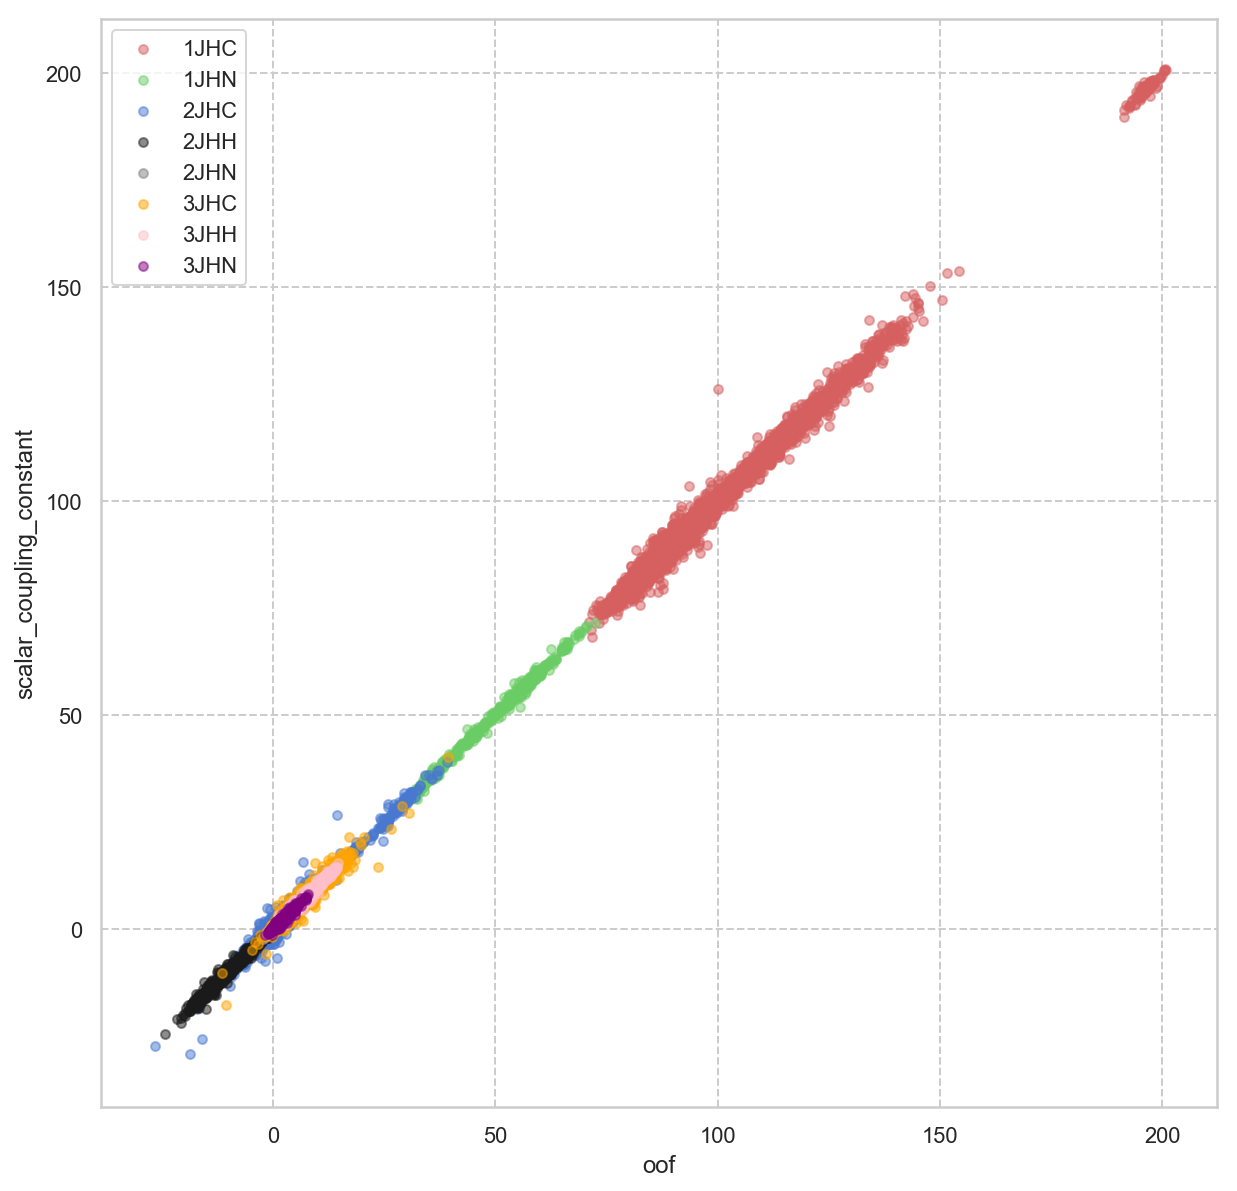

In [15]:
color_dict = {tt:c for tt, c in zip(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'], ['r', 'g', 'b', 'k', 'gray', 'orange', 'pink', 'purple'])}

plt.figure(figsize=(10,10))
ax=plt.subplot(111)
train_s = train.sample(frac=0.1)
for tt in np.sort(train["type"].unique()):
    train_s[train_s["type"]==tt].sample(frac=0.1).plot.scatter(x="oof", y="scalar_coupling_constant", ax=ax, alpha=0.5, color=color_dict[tt], label=tt, rasterized=True)
plt.legend(loc="bottom right")
plt.show()

In [28]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

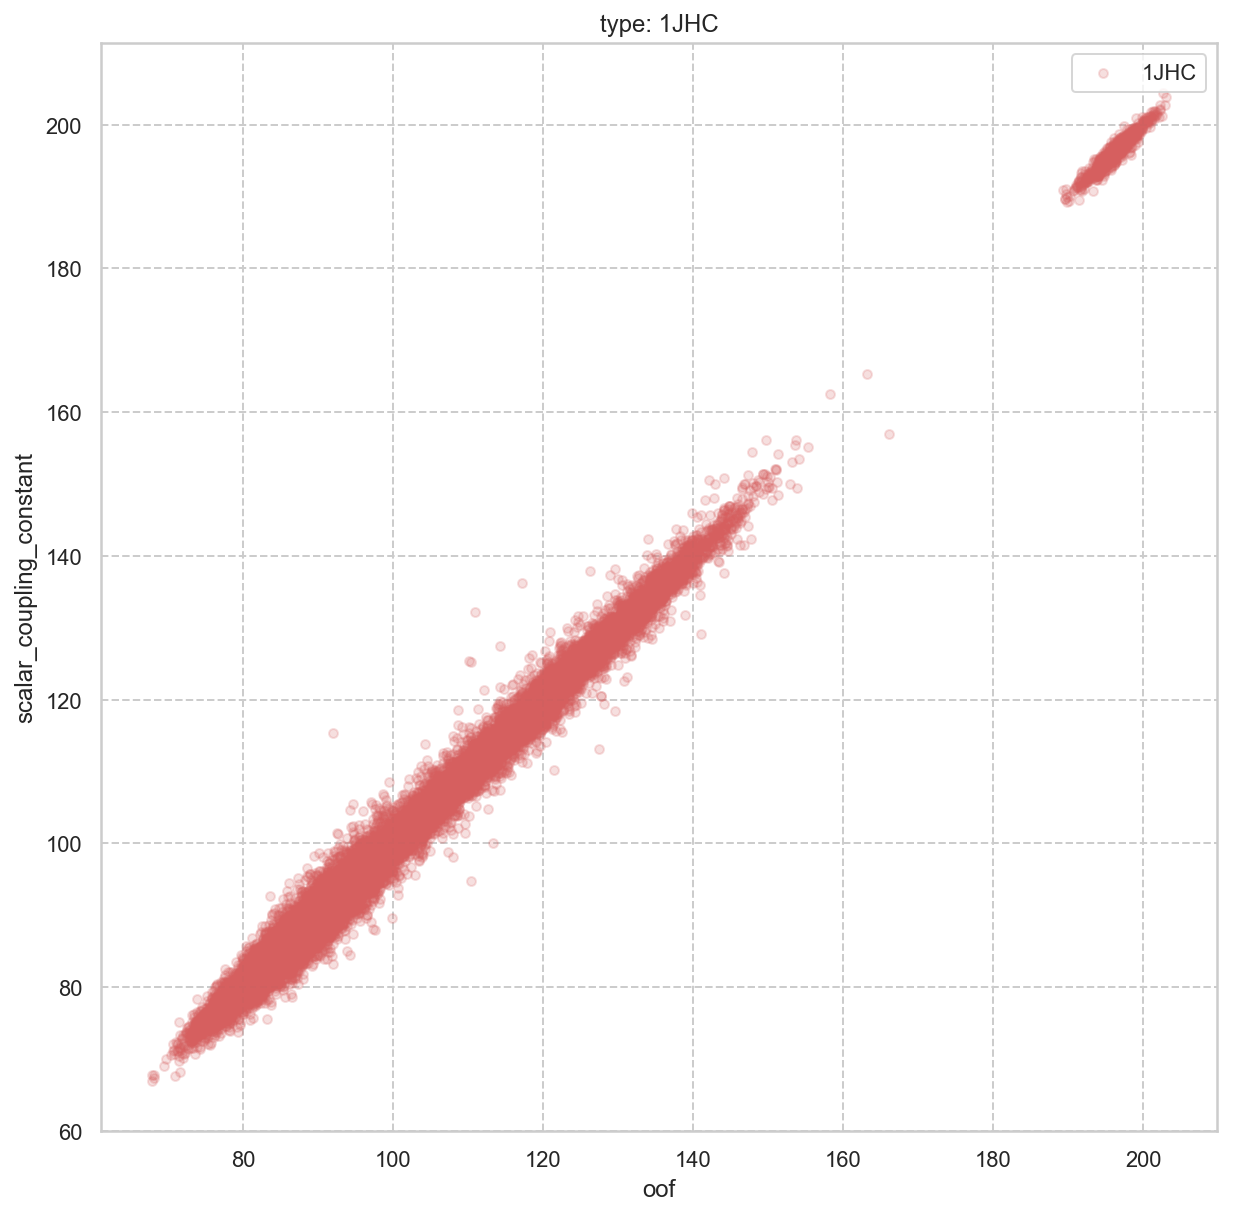

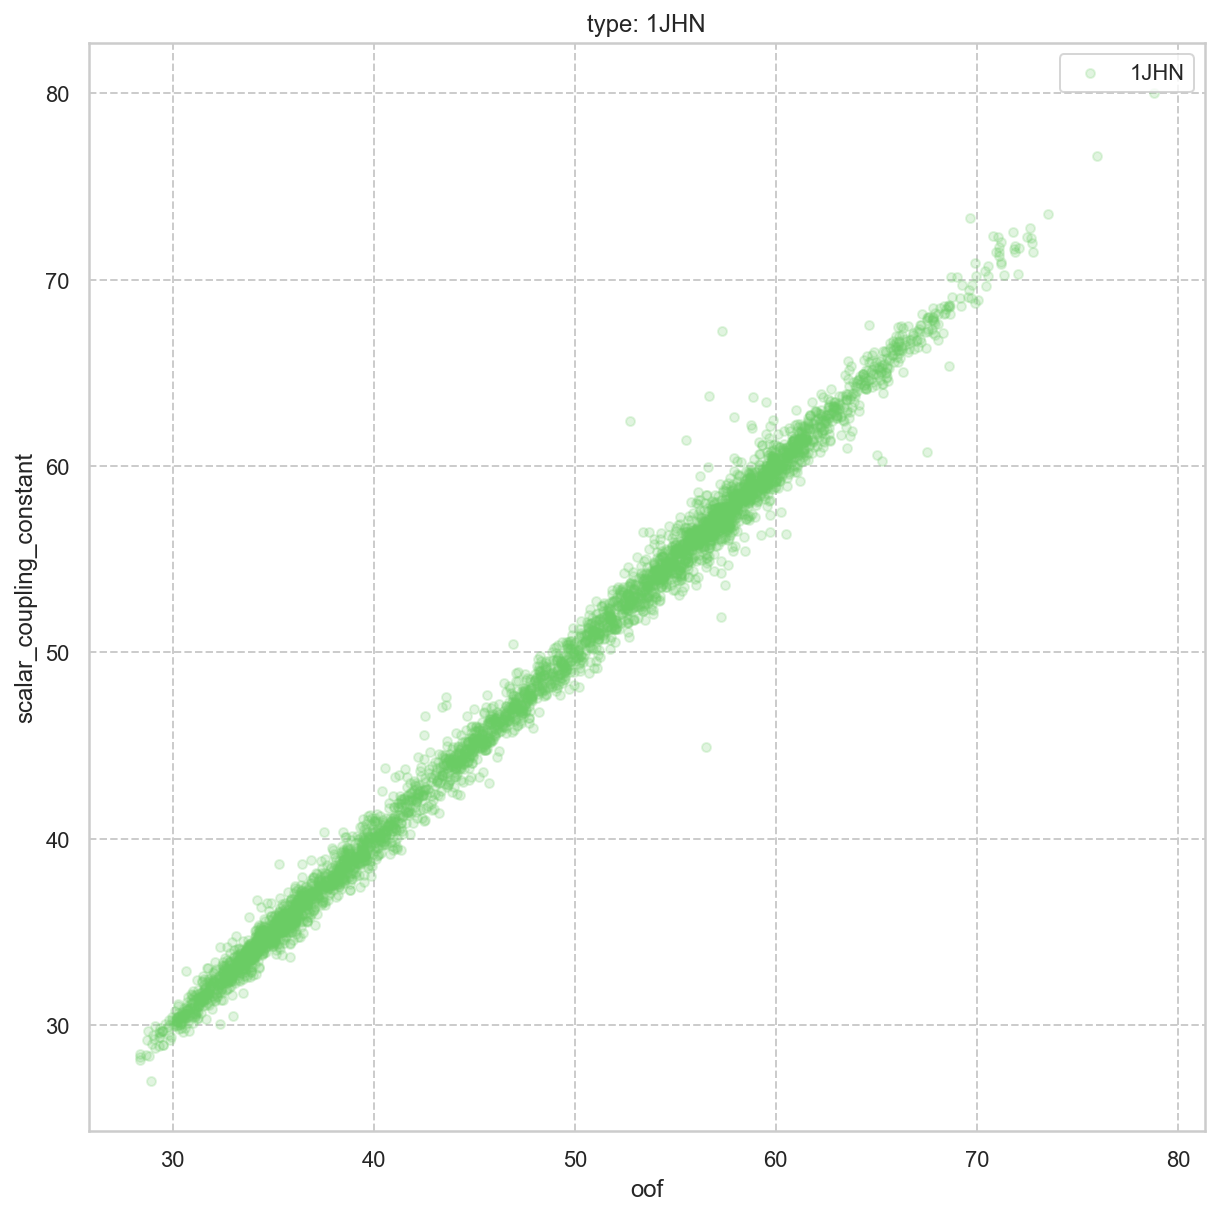

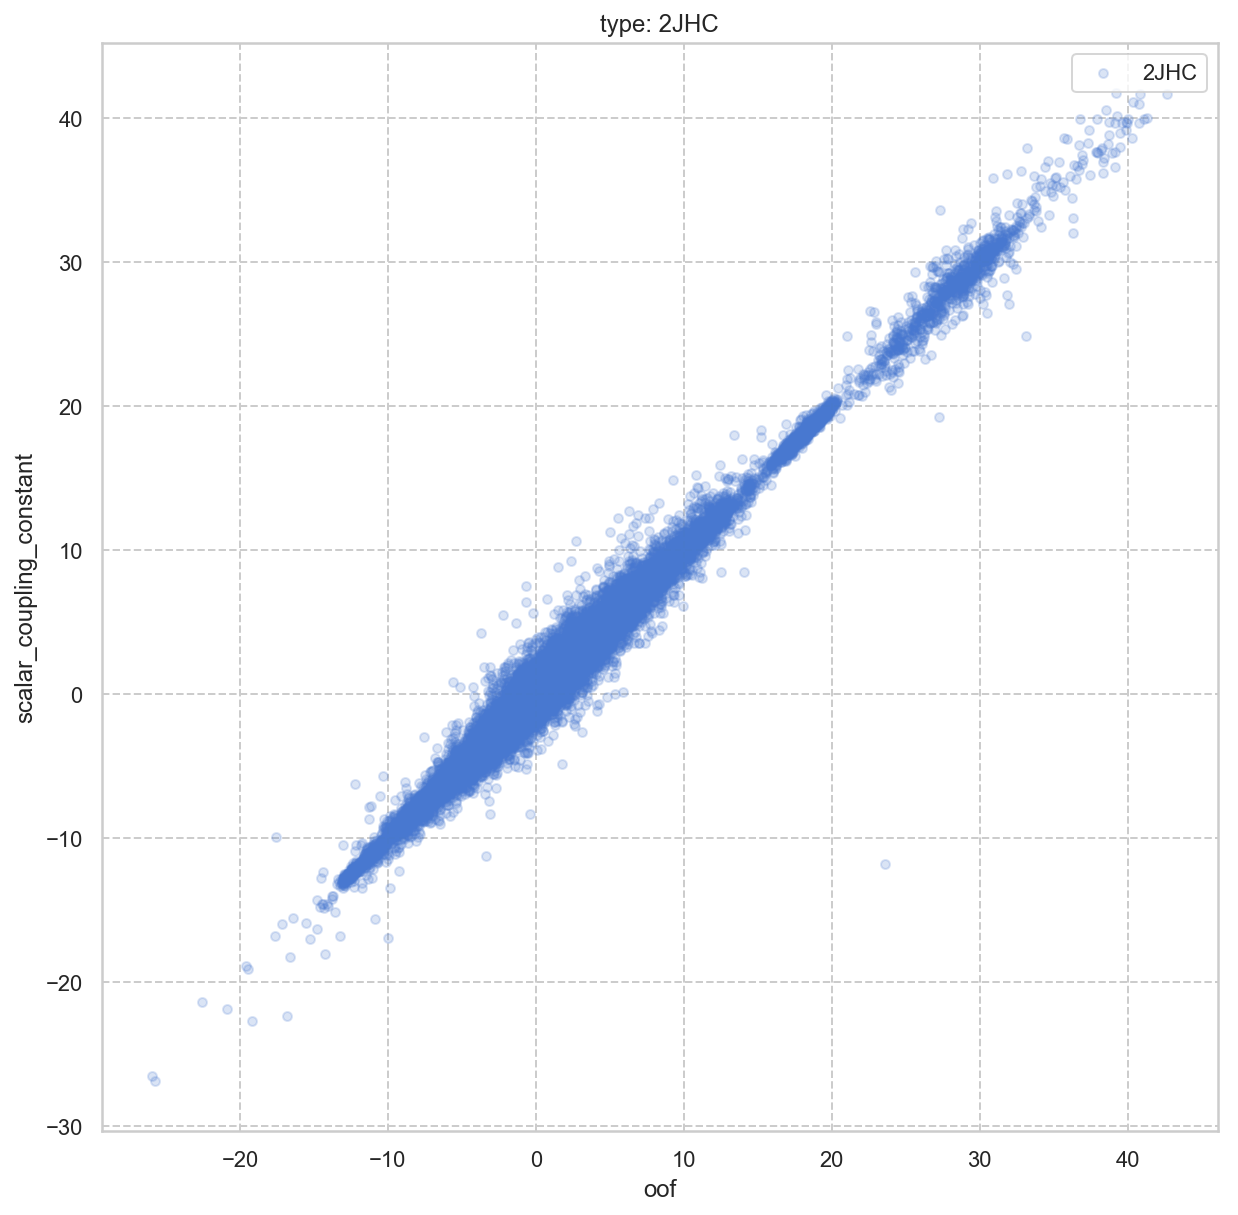

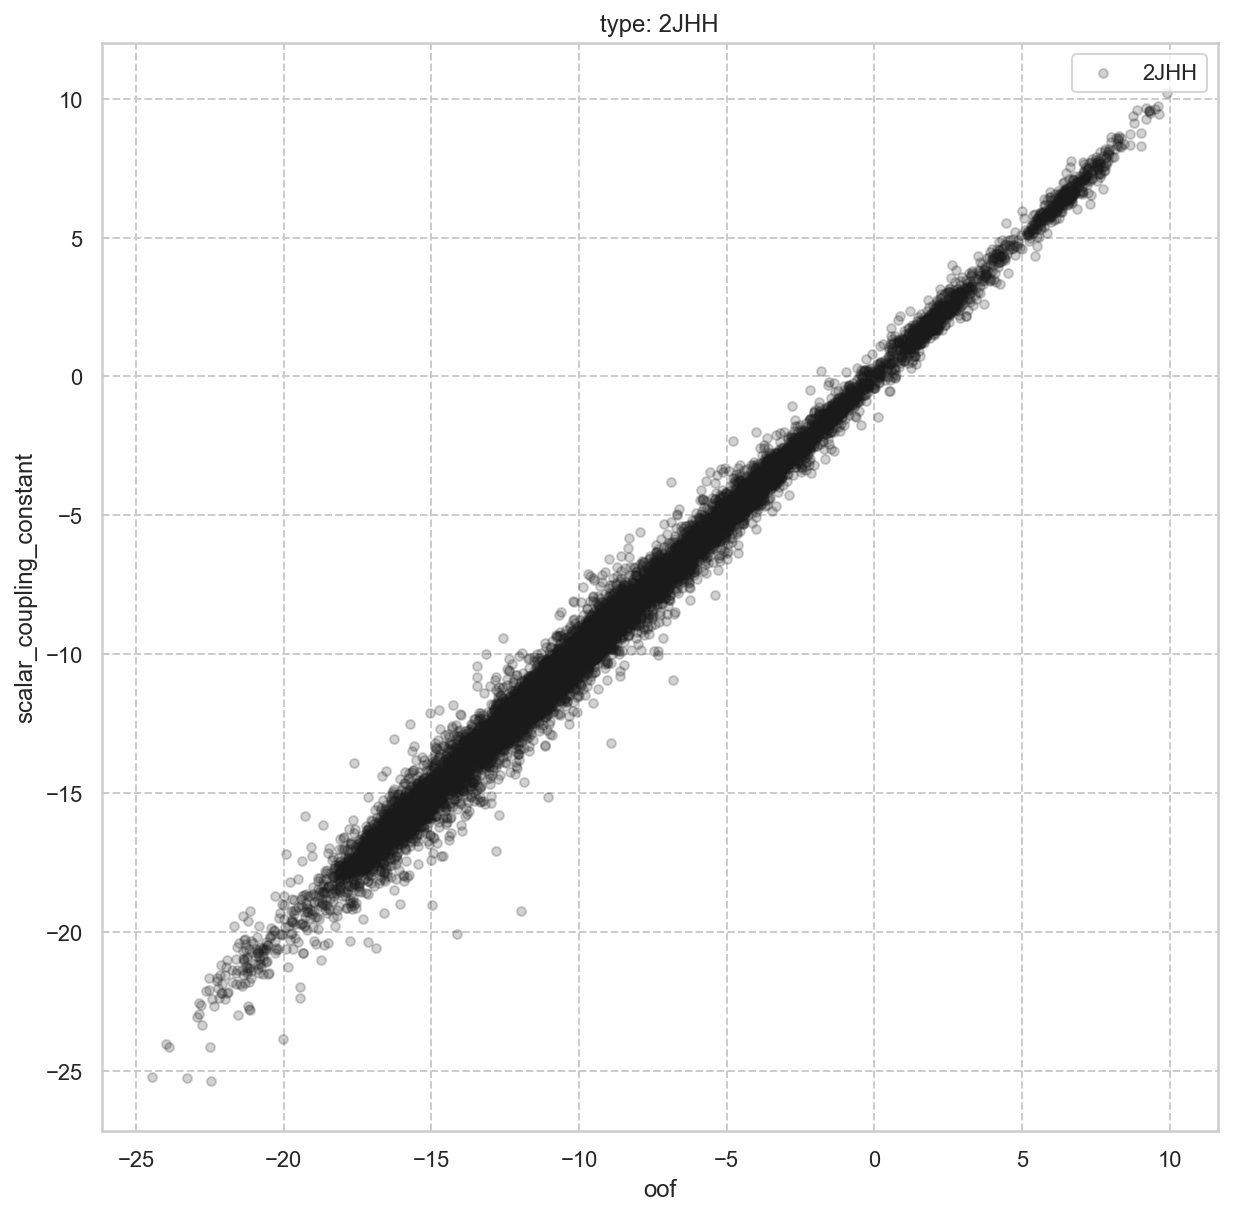

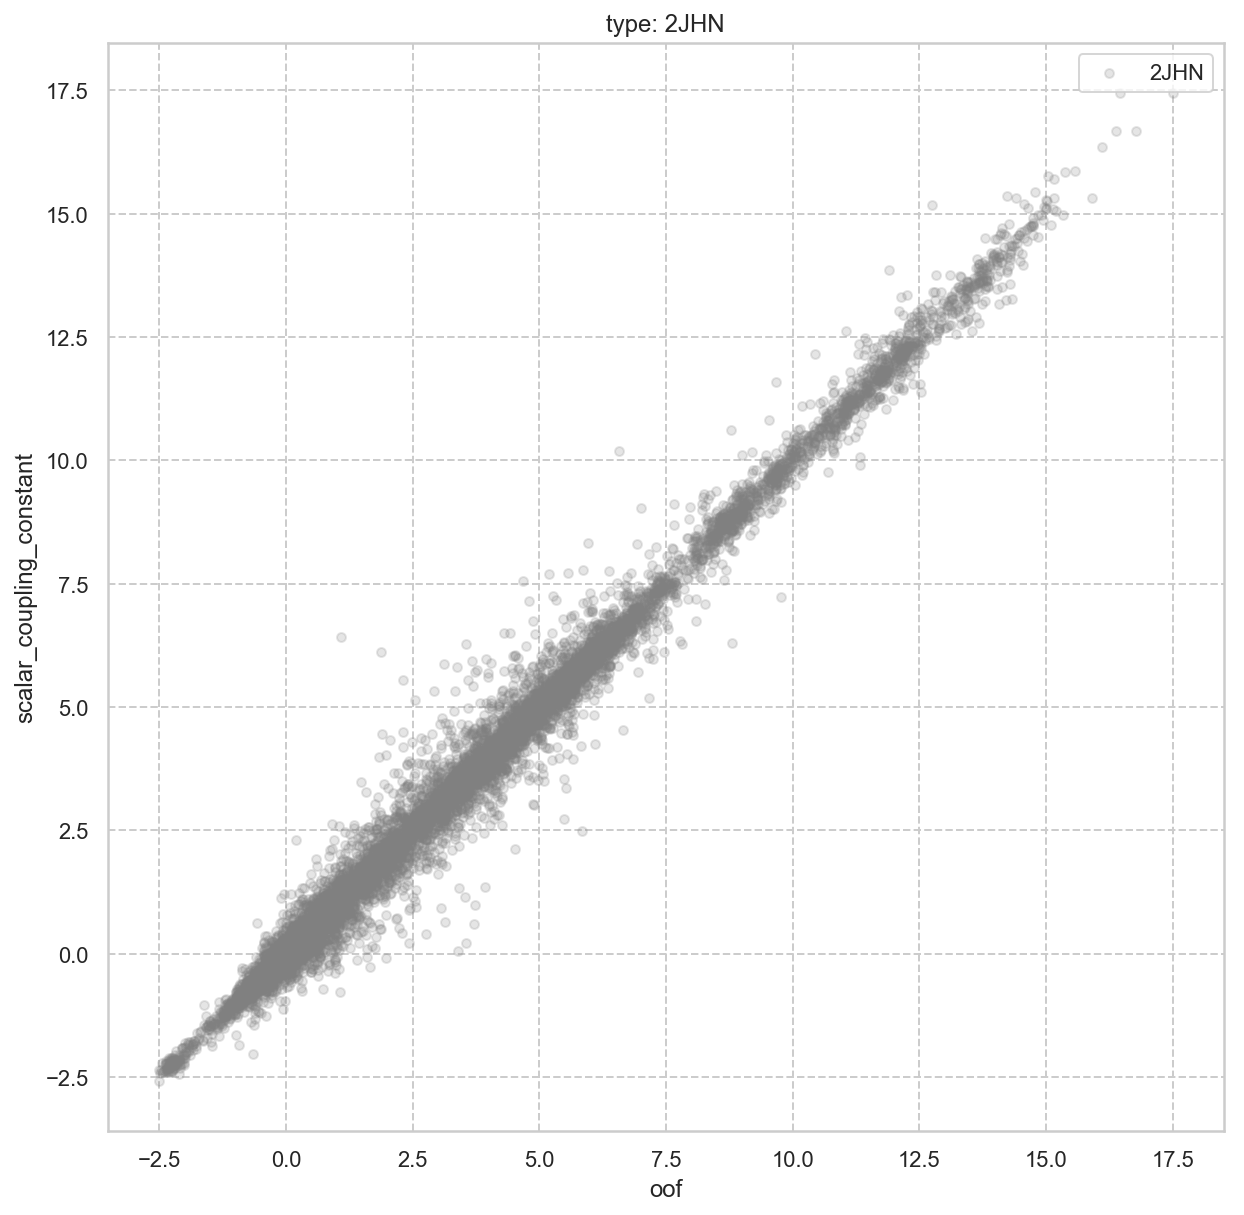

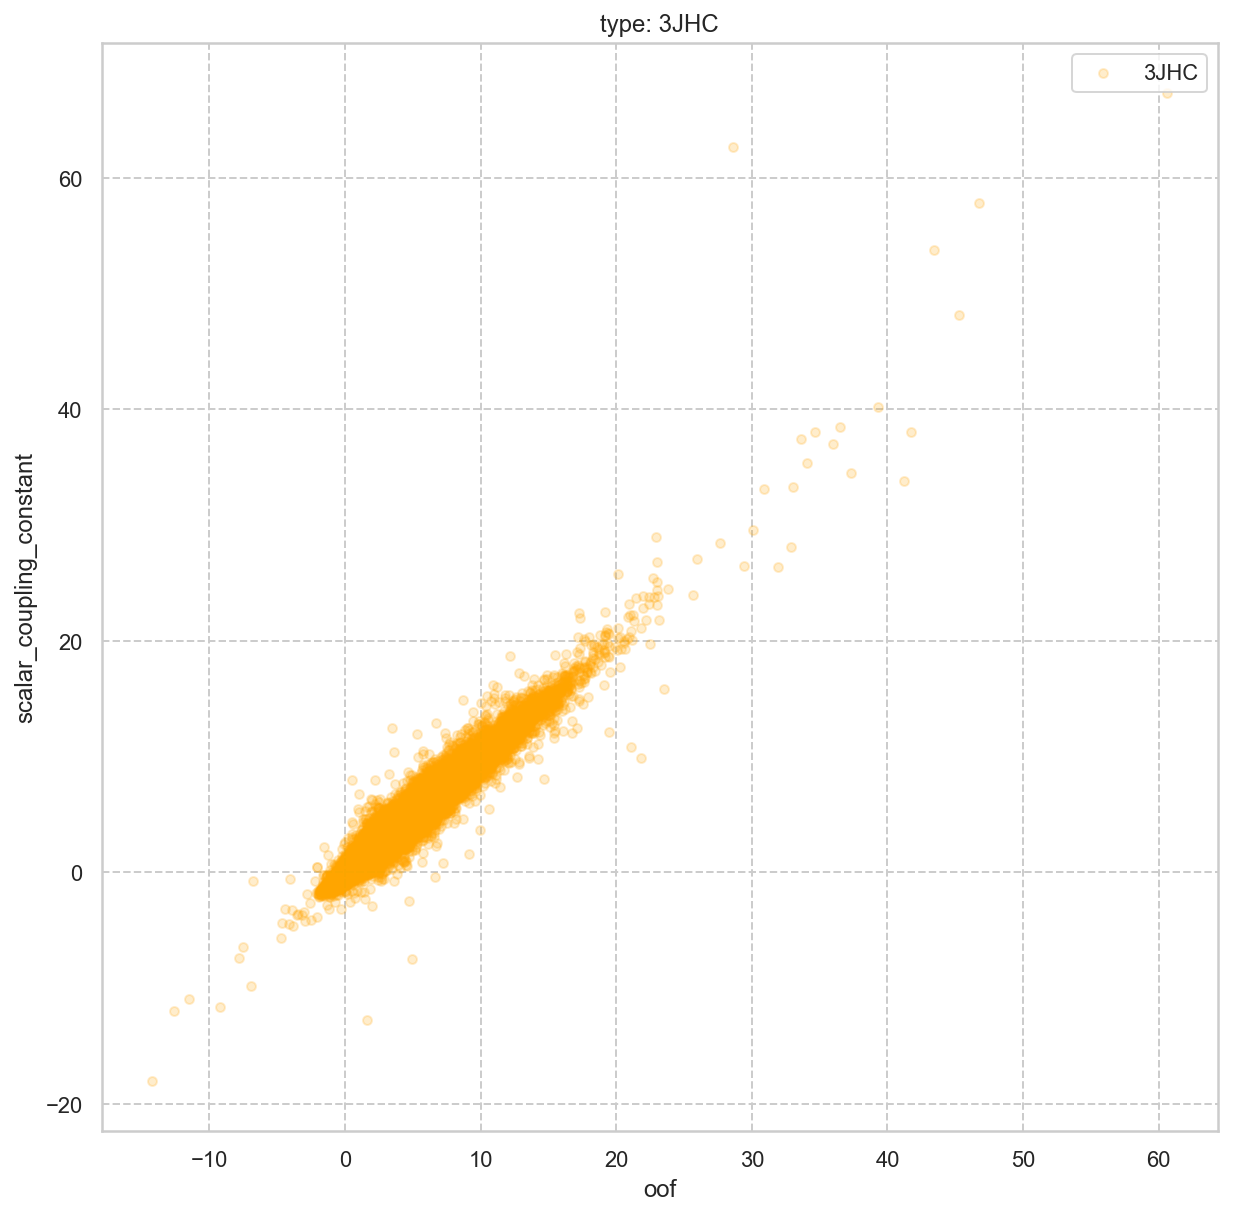

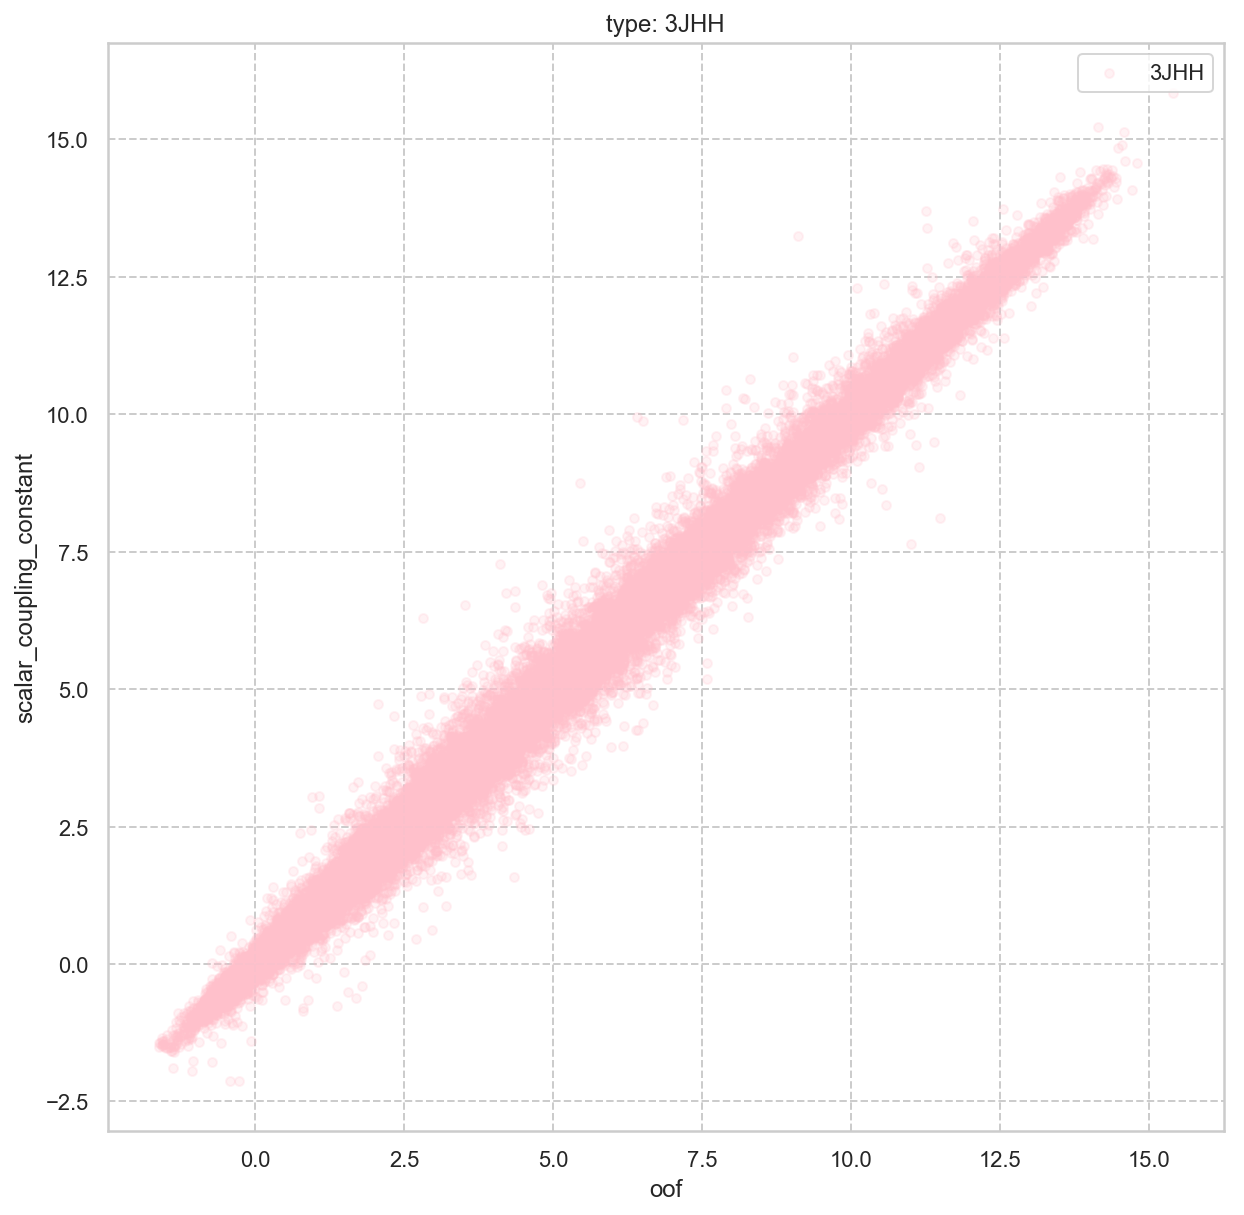

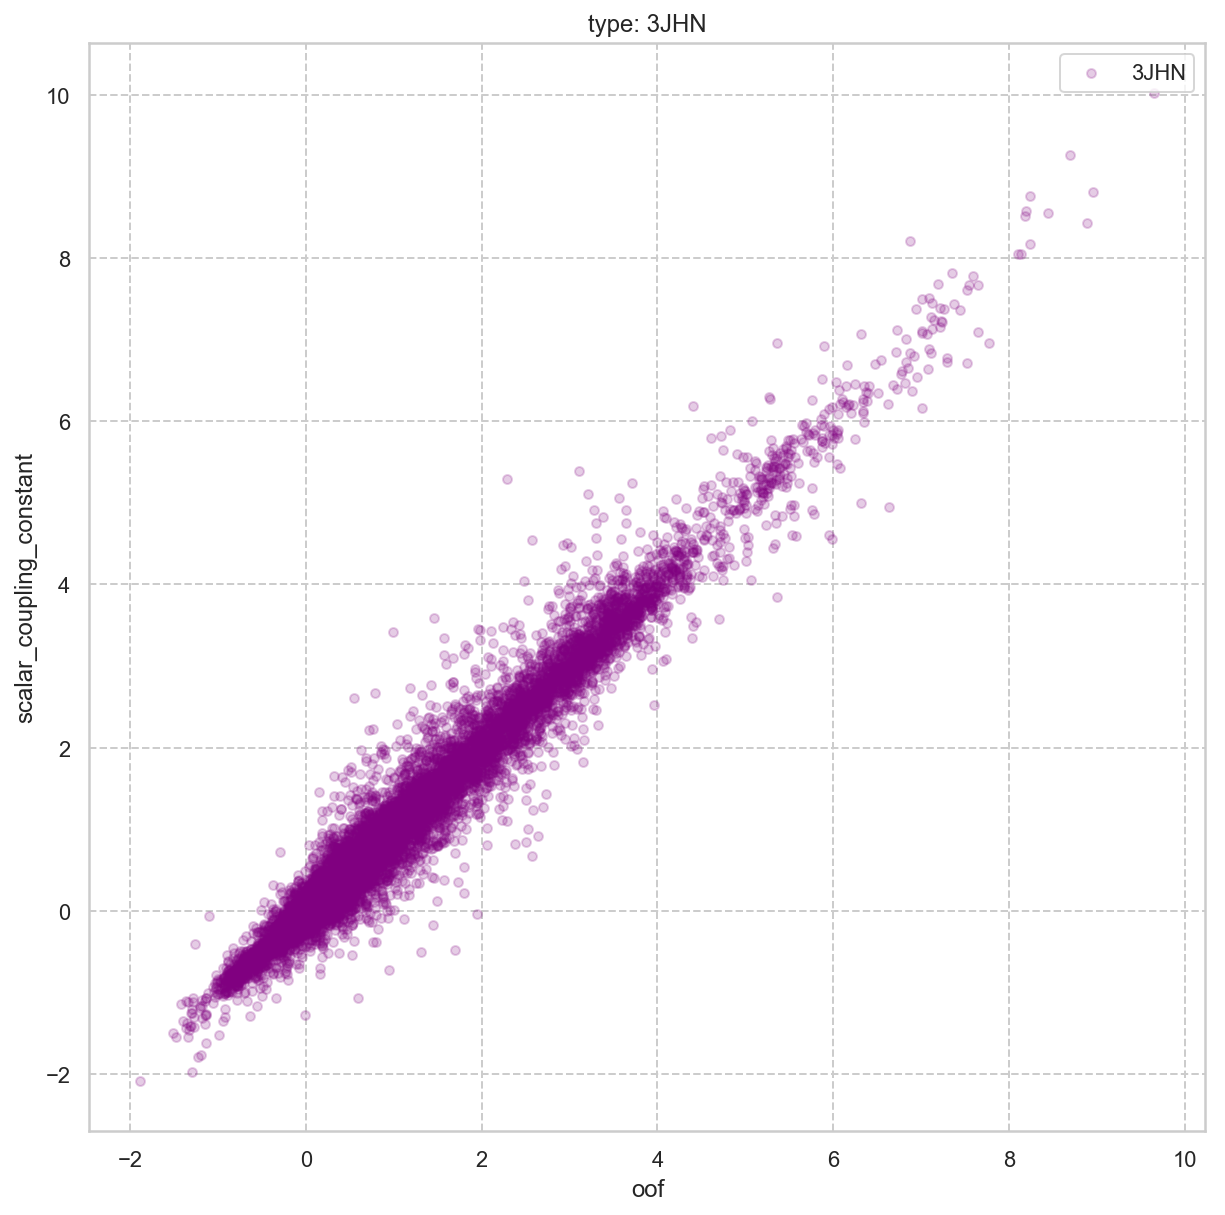

In [24]:
color_dict = {tt:c for tt, c in zip(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'], ['r', 'g', 'b', 'k', 'gray', 'orange', 'pink', 'purple'])}

train_s = train.sample(frac=0.1)
for tt in np.sort(train["type"].unique()):
    plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    train_s[train_s["type"]==tt].plot.scatter(x="oof", y="scalar_coupling_constant", ax=ax, 
                                                               alpha=0.2, color=color_dict[tt], label=tt, rasterized=True)
    plt.title(f"type: {tt}")
    plt.show()

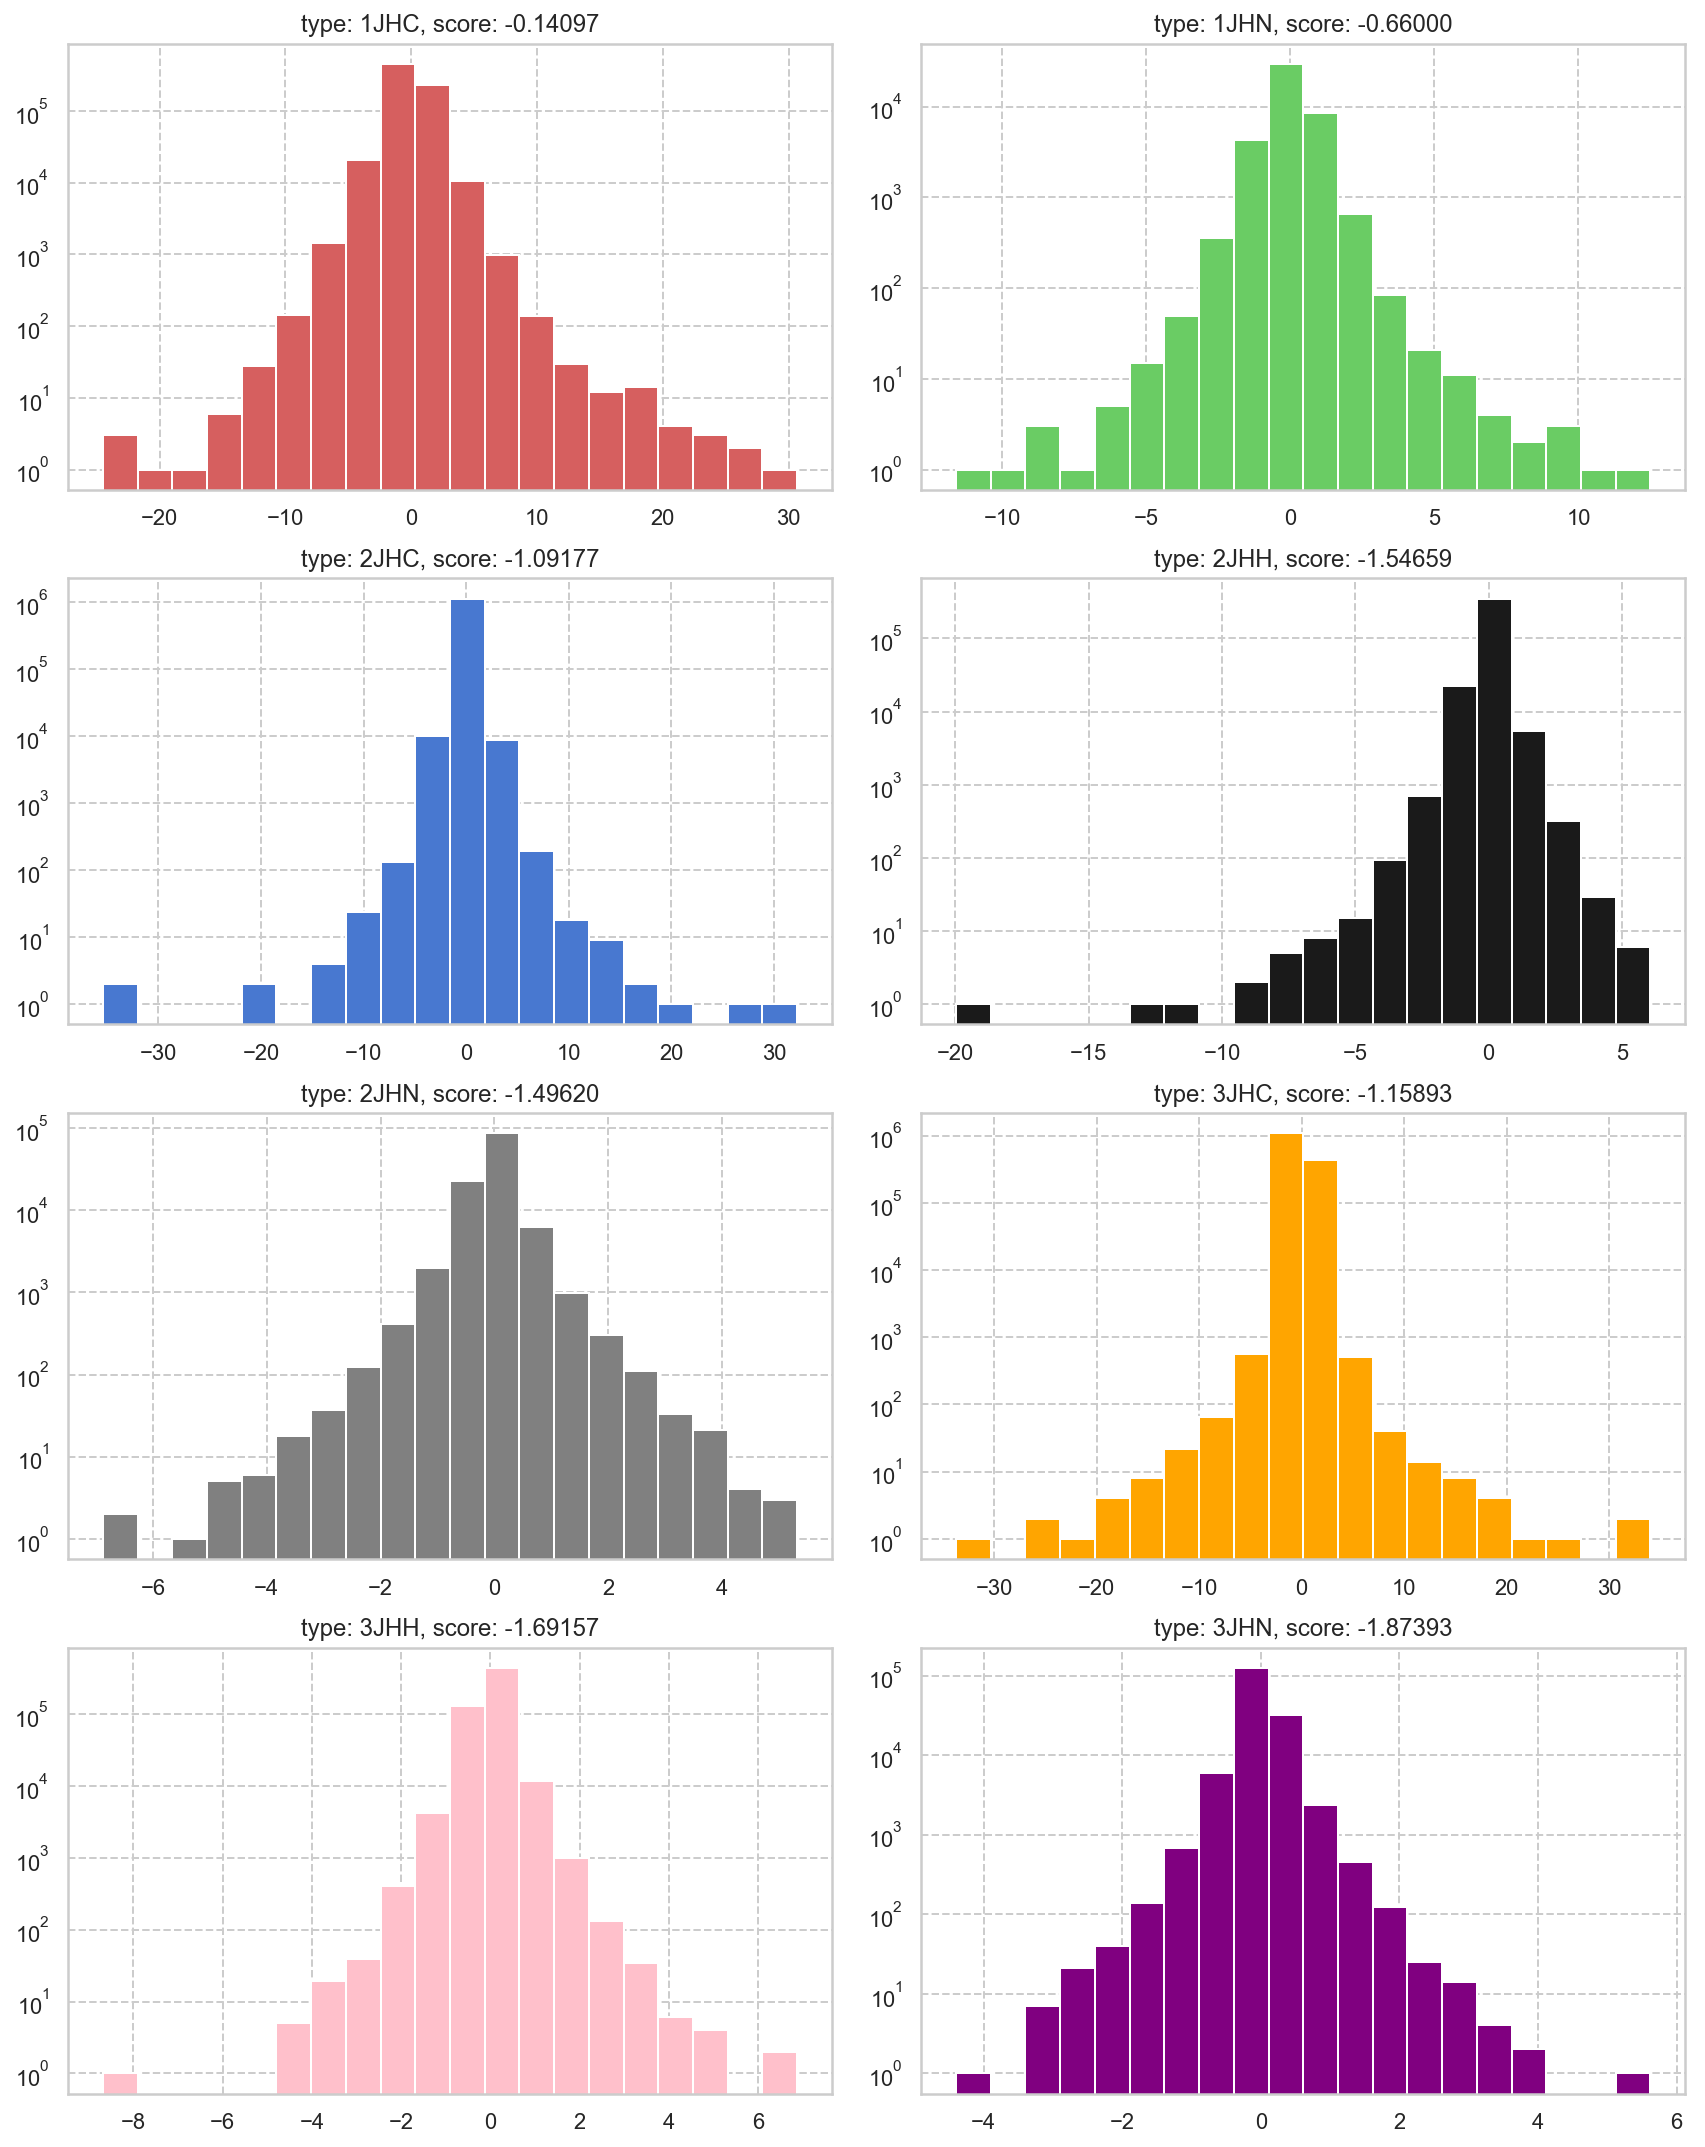

In [36]:
color_dict = {tt:c for tt, c in zip(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'], ['r', 'g', 'b', 'k', 'gray', 'orange', 'pink', 'purple'])}
    
plt.figure(figsize=(12,5*3))

for i, tt in enumerate(np.sort(train["type"].unique())):
    ax=plt.subplot(4,2,i+1)
    
    train_s = train[train["type"]==tt]
    mean_log_mae = group_mean_log_mae(train_s.scalar_coupling_constant, train_s.oof, train_s["type"])
    
    train_s["oof_diff"] = train_s["scalar_coupling_constant"].values - train_s["oof"].values
    train_s["oof_diff"].hist(ax=ax, color=color_dict[tt], label=tt, rasterized=True, bins=20)
    plt.title(f"type: {tt}, score: {mean_log_mae:.5f}")
    plt.yscale("log")
    
plt.tight_layout()
plt.show()

In [41]:
load_dir_csv("../input/", 
             ["test.csv",])

test                             = pd.read_csv(../input//test.csv)
nb of cols                       = 2505542

|index|  id   | molecule_name  |atom_index_0|atom_index_1|type|
|----:|------:|----------------|-----------:|-----------:|----|
|    0|4658147|dsgdb9nsd_000004|           2|           0|2JHC|
|    1|4658148|dsgdb9nsd_000004|           2|           1|1JHC|
|    2|4658149|dsgdb9nsd_000004|           2|           3|3JHH|
|    3|4658150|dsgdb9nsd_000004|           3|           0|1JHC|
|    4|4658151|dsgdb9nsd_000004|           3|           1|2JHC|




In [6]:
train.head(100)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.25410
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.25480
7,7,dsgdb9nsd_000001,3,0,1JHC,84.80930
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.25430
9,9,dsgdb9nsd_000001,4,0,1JHC,84.80950


In [7]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.01270,1.08580,0.00800
1,dsgdb9nsd_000001,1,H,0.00215,-0.00603,0.00198
2,dsgdb9nsd_000001,2,H,1.01173,1.46375,0.00028
3,dsgdb9nsd_000001,3,H,-0.54082,1.44753,-0.87664
4,dsgdb9nsd_000001,4,H,-0.52381,1.43793,0.90640


In [26]:
def matrics_rotate_(row, theta):
    # x0 = np.random.random()
    # y1 = 2*math.pi*np.random.random()
    # y2 = 2*math.pi*np.random.random()
    x0 = theta[0]
    y1 = theta[1]
    y2 = theta[2]
    r1 = math.sqrt(1.0-x0)
    r2 = math.sqrt(x0)
    u0 = math.cos(y2)*r2
    u1 = math.sin(y1)*r1
    u2 = math.cos(y1)*r1
    u3 = math.sin(y2)*r2
    coefi = 2.0*u0*u0-1.0
    coefuu = 2.0
    coefe = 2.0*u0
    r = np.zeros(shape=(3, 3))
    r[0, 0] = coefi+coefuu*u1*u1
    r[1, 1] = coefi+coefuu*u2*u2
    r[2, 2] = coefi+coefuu*u3*u3

    r[1, 2] = coefuu*u2*u3-coefe*u1
    r[2, 0] = coefuu*u3*u1-coefe*u2
    r[0, 1] = coefuu*u1*u2-coefe*u3

    r[2, 1] = coefuu*u3*u2+coefe*u1
    r[0, 2] = coefuu*u1*u3+coefe*u2
    r[1, 0] = coefuu*u2*u1+coefe*u3
    return np.dot([row.x, row.y, row.z], r)

rd.seed(SEED)
rotated_structures = []
for i, g in tqdm(structures.groupby("molecule_name")):
    theta = [np.random.random(), 2*np.random.random(), 2*np.random.random()]
    rotated = g.apply(lambda row: matrics_rotate_(row, theta), axis=1, result_type="expand")
    rotated.columns = ["x", "y", "z"]
    rotated["molecule_name"] = i
    rotated["atom_index"] = g.atom_index
    rotated["atom"] = g.atom
    rotated_structures += [rotated]
    # break
    
rotated_structures_df = pd.concat(rotated_structures, axis=0)
rotated_structures_df[structures.columns].to_csv(f"../input/rotated_structures_{SEED}.csv")

In [36]:
assert structures.shape[0] == rotated_structures_df.shape[0]

In [37]:
rotated_structures_df[structures.columns].head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,0.85409,-0.18319,0.64511
1,dsgdb9nsd_000001,1,H,-0.00397,0.00380,-0.00384
2,dsgdb9nsd_000001,2,H,0.93708,0.62072,1.37940
3,dsgdb9nsd_000001,3,H,0.71895,-1.13561,1.16181
4,dsgdb9nsd_000001,4,H,1.76426,-0.22164,0.04306


In [42]:
f = "type"
lbl = LabelEncoder()
lbl.fit(list(train[f].values) + list(test[f].values))

LabelEncoder()

In [43]:
lbl.classes_

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype='<U4')

In [45]:
pd.DataFrame({"idx": range(8), "type":lbl.inverse_transform(range(8))})

,idx,type
0,0,1JHC
1,1,1JHN
2,2,2JHC
3,3,2JHH
4,4,2JHN
5,5,3JHC
6,6,3JHH
7,7,3JHN


In [46]:
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.02240,0.25458,1.25862,0.27201
1,dsgdb9nsd_000001,1,2,2JHH,-11.03470,0.35298,2.85839,-3.43360
2,dsgdb9nsd_000001,1,3,2JHH,-11.03250,0.35294,2.85852,-3.43387
3,dsgdb9nsd_000001,1,4,2JHH,-11.03190,0.35293,2.85855,-3.43393
4,dsgdb9nsd_000001,2,0,1JHC,83.02220,0.25459,1.25861,0.27201


In [72]:
train_scc = pd.concat([train, scalar_coupling_contributions.drop("type", axis=1)], axis=1)

In [49]:
train_scc[["scalar_coupling_constant", "fc", "sd", "pso", "dso"]].head()

,scalar_coupling_constant,fc,sd,pso,dso
0,84.80760,83.02240,0.25458,1.25862,0.27201
1,-11.25700,-11.03470,0.35298,2.85839,-3.43360
2,-11.25480,-11.03250,0.35294,2.85852,-3.43387
3,-11.25430,-11.03190,0.35293,2.85855,-3.43393
4,84.80740,83.02220,0.25459,1.25861,0.27201


In [50]:
train_scc[["scalar_coupling_constant", "fc", "sd", "pso", "dso"]].corr()

,scalar_coupling_constant,fc,sd,pso,dso
scalar_coupling_constant,1.00000,0.99992,0.33834,-0.04658,0.55696
fc,0.99992,1.00000,0.33372,-0.05096,0.55524
sd,0.33834,0.33372,1.00000,0.51799,-0.19993
pso,-0.04658,-0.05096,0.51799,1.00000,-0.73992
dso,0.55696,0.55524,-0.19993,-0.73992,1.00000


In [60]:
train_scc.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760,dsgdb9nsd_000001,1,0,1JHC,83.02240,0.25458,1.25862,0.27201
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700,dsgdb9nsd_000001,1,2,2JHH,-11.03470,0.35298,2.85839,-3.43360
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480,dsgdb9nsd_000001,1,3,2JHH,-11.03250,0.35294,2.85852,-3.43387
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430,dsgdb9nsd_000001,1,4,2JHH,-11.03190,0.35293,2.85855,-3.43393
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740,dsgdb9nsd_000001,2,0,1JHC,83.02220,0.25459,1.25861,0.27201


In [65]:
color_dict = {tt:c for tt, c in zip(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'], ['r', 'g', 'b', 'k', 'gray', 'orange', 'pink', 'purple'])}

In [76]:
train_s.head()


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,molecule_name,atom_index_0,atom_index_1,fc,sd,pso,dso
2165766,2165766,dsgdb9nsd_067504,12,3,2JHC,0.36830,dsgdb9nsd_067504,12,3,0.43598,0.00481,0.21826,-0.29075
2595523,2595523,dsgdb9nsd_078413,12,4,2JHC,2.47313,dsgdb9nsd_078413,12,4,2.19625,0.12838,0.29350,-0.14499
1379141,1379141,dsgdb9nsd_044708,10,2,1JHC,91.33630,dsgdb9nsd_044708,10,2,89.70750,0.23251,0.45242,0.94388
4002706,4002706,dsgdb9nsd_112964,18,6,3JHC,4.70097,dsgdb9nsd_112964,18,6,4.76165,0.02176,0.17465,-0.25710
3005769,3005769,dsgdb9nsd_088488,12,1,1JHC,105.61200,dsgdb9nsd_088488,12,1,103.98500,0.19646,0.31507,1.11590


In [77]:
train_s[train_s["type"]==tt].head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,molecule_name,atom_index_0,atom_index_1,fc,sd,pso,dso
704730,704730,dsgdb9nsd_022899,10,2,3JHN,0.47381,dsgdb9nsd_022899,10,2,0.46719,0.00560,-0.02637,0.02739
207552,207552,dsgdb9nsd_007678,13,7,3JHN,0.19227,dsgdb9nsd_007678,13,7,0.17894,0.00566,-0.00316,0.01082
3376675,3376675,dsgdb9nsd_097299,14,3,3JHN,0.03006,dsgdb9nsd_097299,14,3,0.12420,-0.02763,0.00931,-0.07582
4458531,4458531,dsgdb9nsd_123450,9,8,3JHN,0.84867,dsgdb9nsd_123450,9,8,0.99868,-0.02152,-0.22076,0.09227
4373807,4373807,dsgdb9nsd_121501,15,8,3JHN,0.20655,dsgdb9nsd_121501,15,8,0.30865,0.00777,0.02439,-0.13425


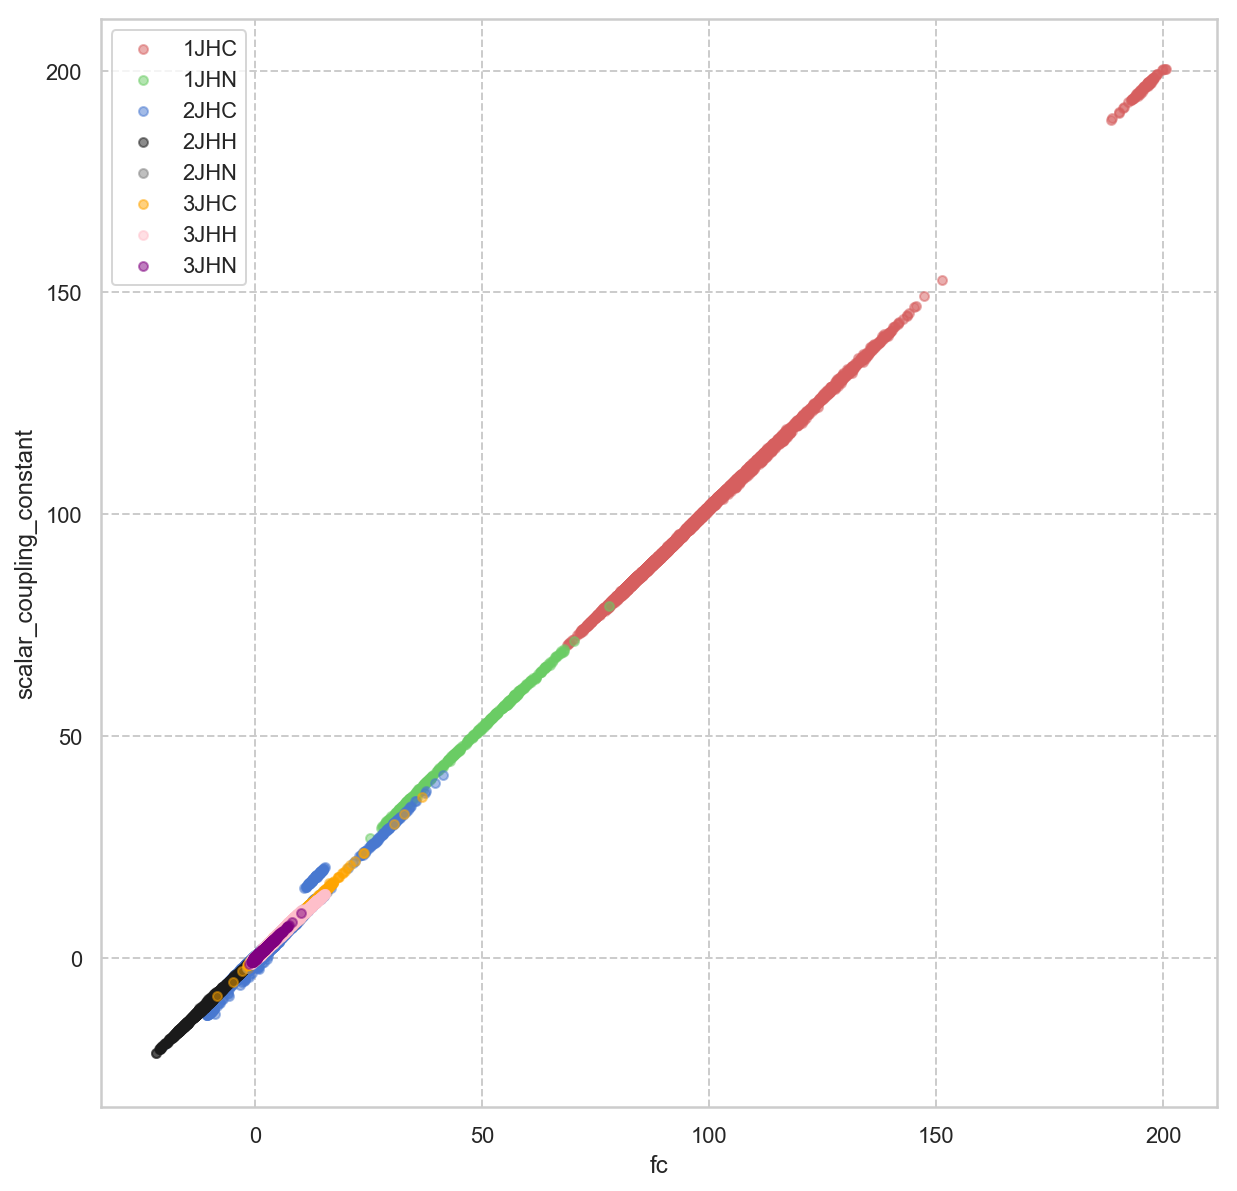

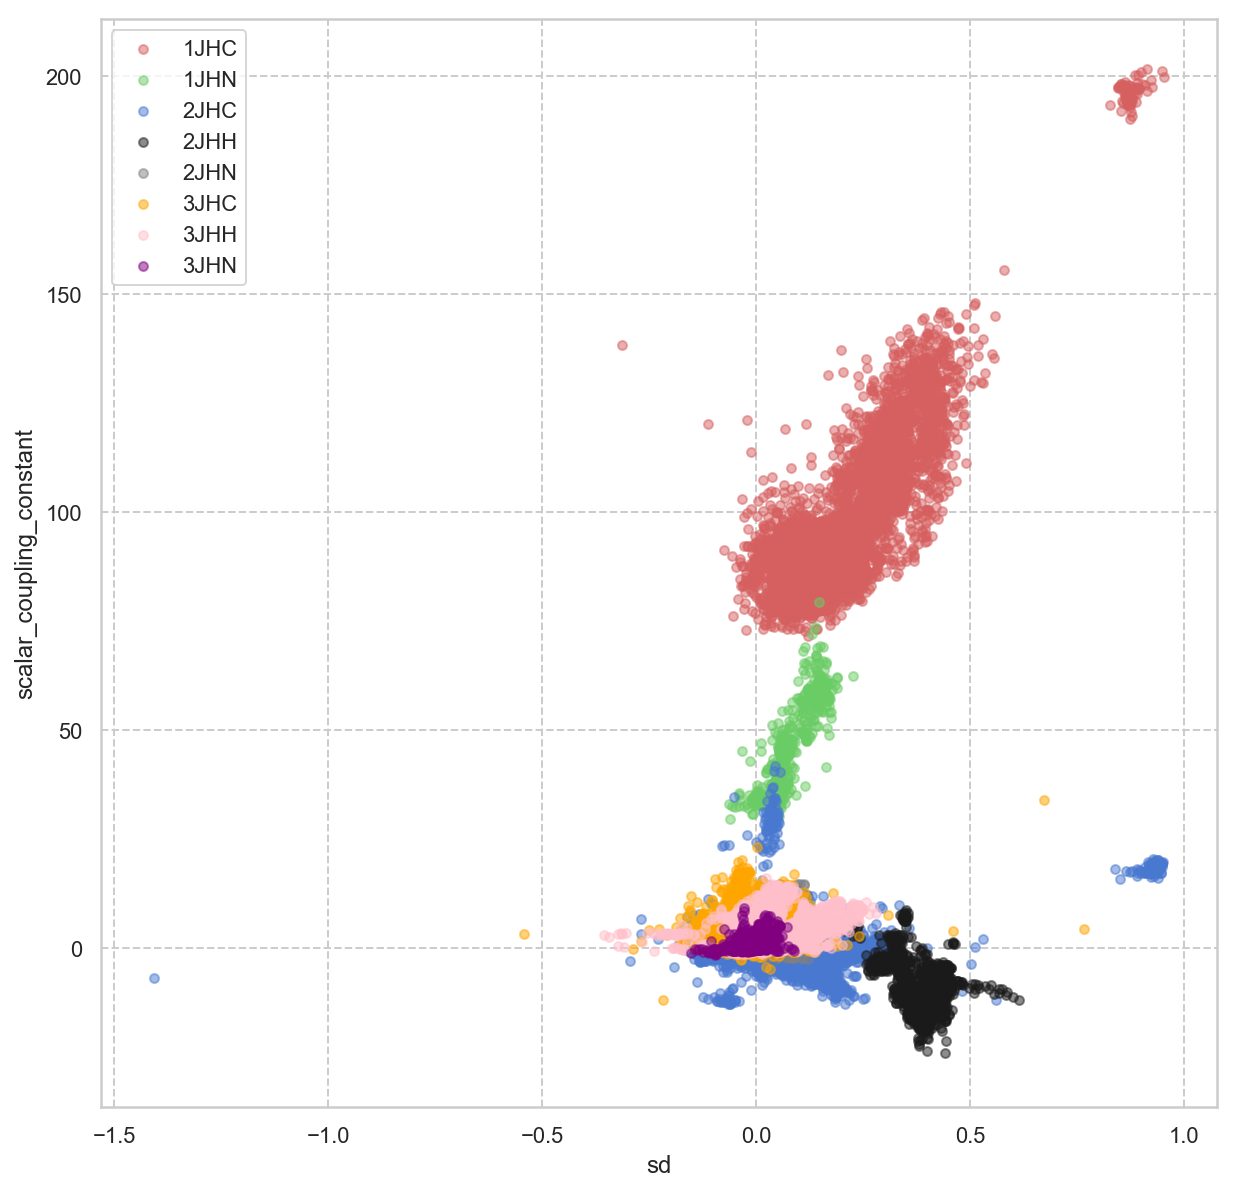

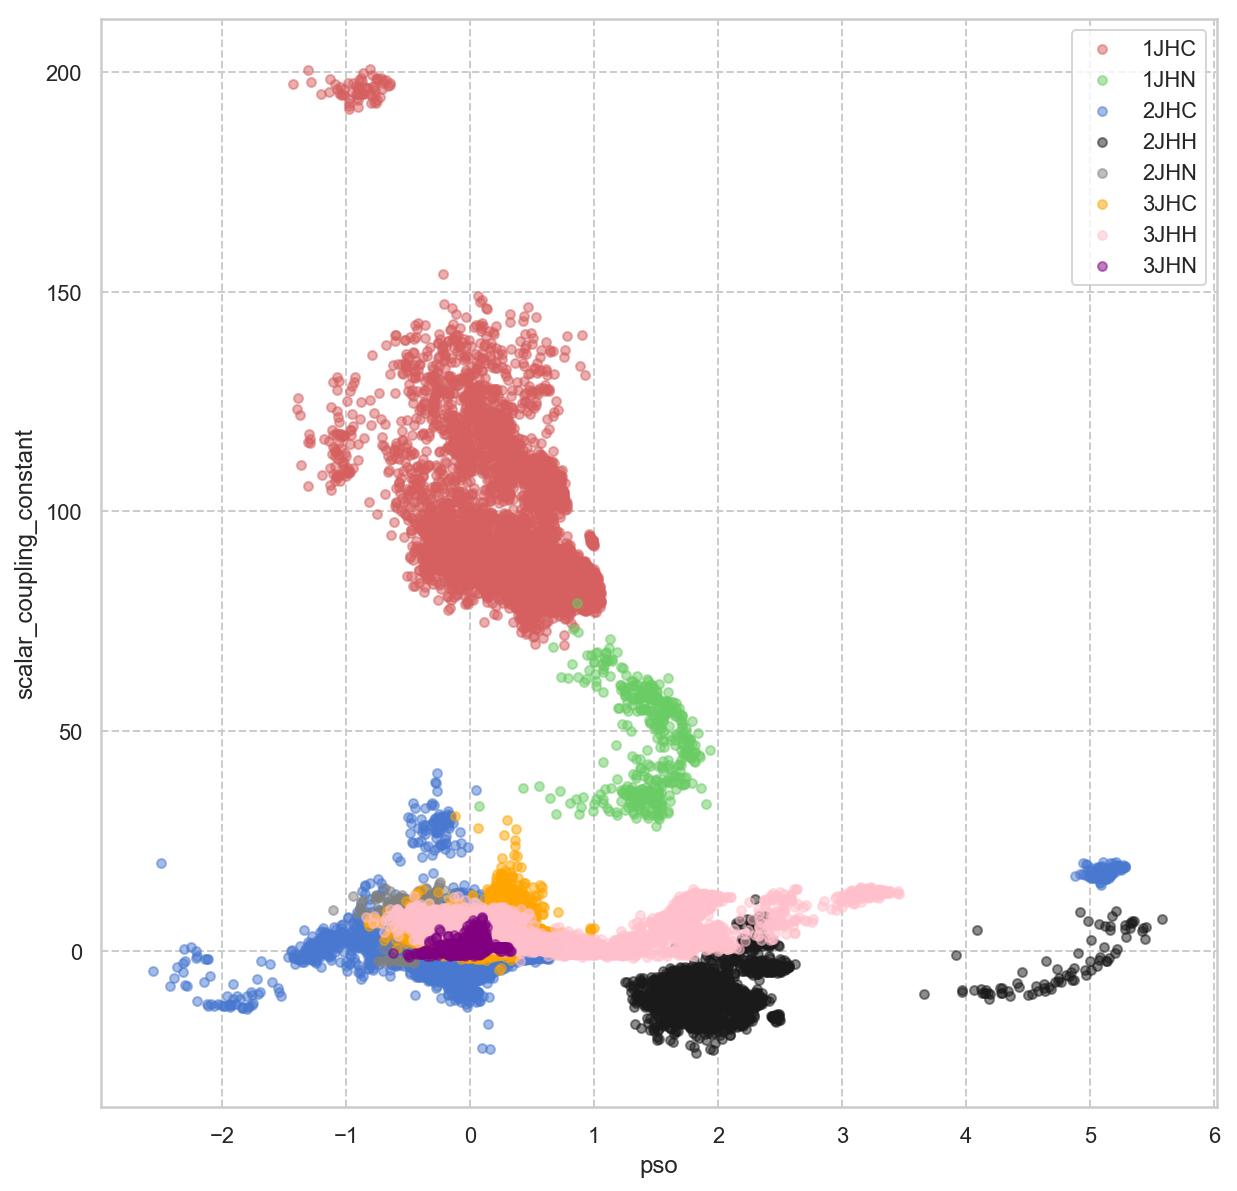

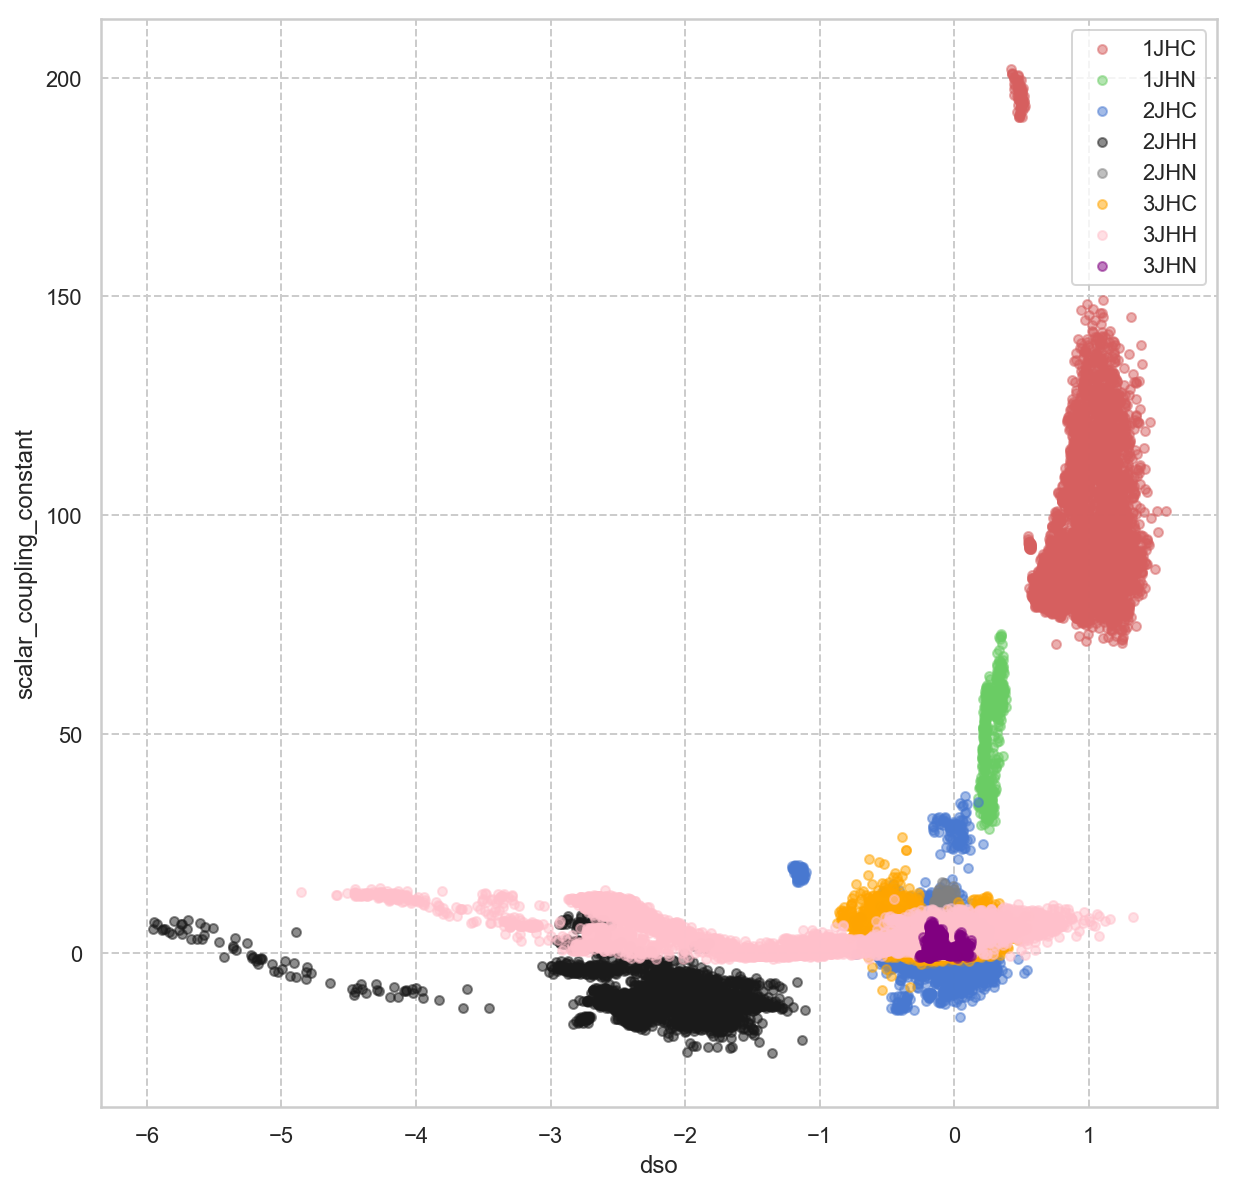

In [81]:
for t in["fc", "sd", "pso", "dso"]:
    plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    train_s = train_scc.sample(frac=0.1)
    for tt in np.sort(train["type"].unique()):
        train_s[train_s["type"]==tt].sample(frac=0.1).plot.scatter(x=t, y="scalar_coupling_constant", ax=ax, alpha=0.5, color=color_dict[tt], label=tt, rasterized=True)
    plt.legend(loc="best")
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


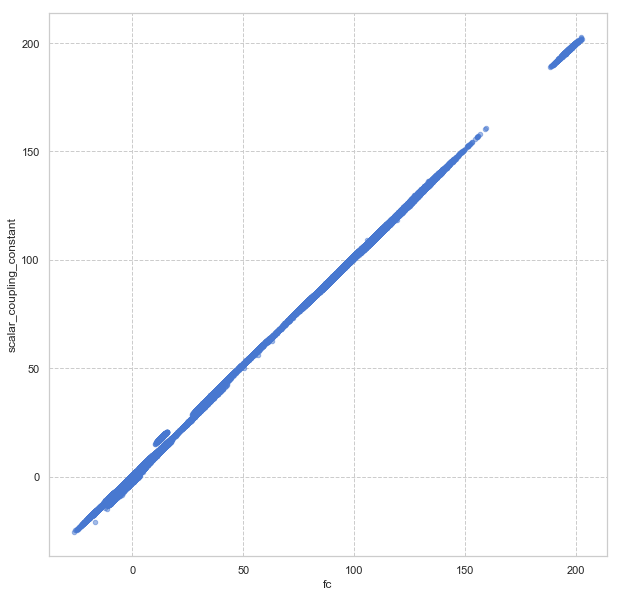

In [57]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
train_scc.sample(frac=0.1).plot.scatter(x="fc", y="scalar_coupling_constant", ax=ax, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


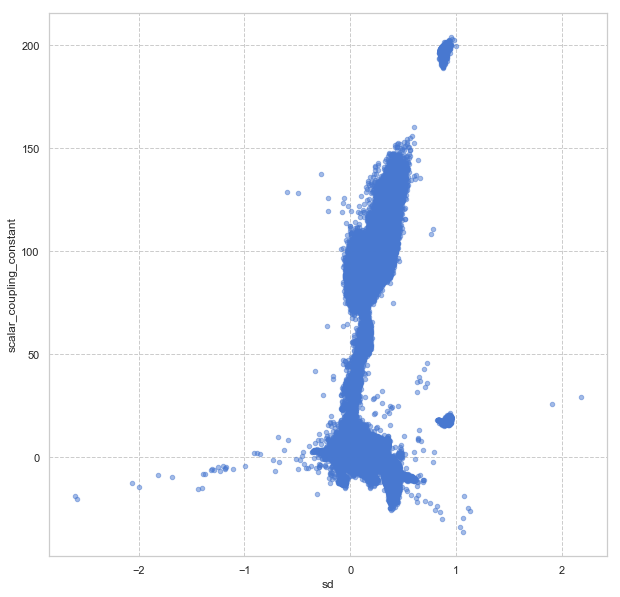

In [58]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
train_scc.sample(frac=0.1).plot.scatter(x="sd", y="scalar_coupling_constant", ax=ax, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


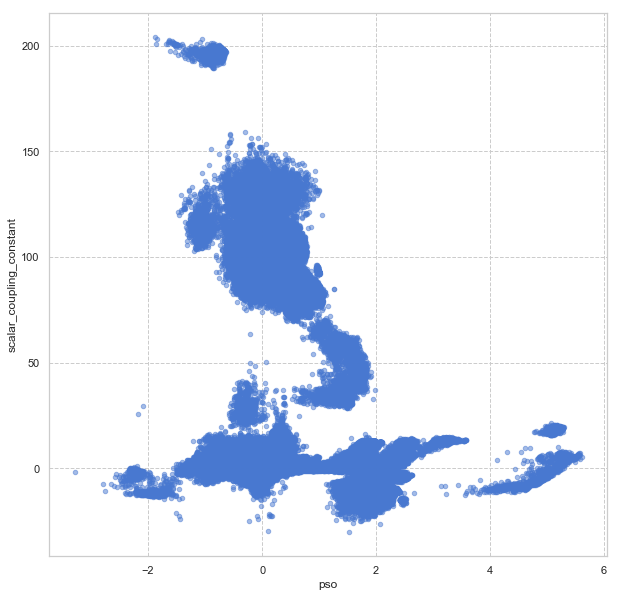

In [59]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
train_scc.sample(frac=0.1).plot.scatter(x="pso", y="scalar_coupling_constant", ax=ax, alpha=0.5)

In [39]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=2)

In [ ]:
group_kfold.split(X, y, groups)

In [ ]:

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array([0, 0, 2, 2])
group_kfold.get_n_splits(X, y, groups)

print(group_kfold)
pKFold(n_splits=2)
for train_index, test_index in group_kfold.split(X, y, groups):